## Notebook set up

**Your task**: Apply at least two different feature engineering techniques to the `housing_df` dataframe to improve the dataset. At the end of the notebook, your engineered dataset and the original dataset will be used to train a linear regression model to predict `MedHouseVal`. Your goal is to achieve better model performance via feature engineering.

**Note**: If you have read ahead or you are familiar with the basics of training ML models, no there is no train-test split and yes, this means data leakage/genralizability is a concern. We will cover those topics in the next unit. For now, the goal is to keep things simple while still giving you an idea of how your feature engineering effects model performance.

Before applying transformations, explore the dataset to understand what techniques would be most beneficial.

### Import libraries

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Set random seed for reproducibility
np.random.seed(315)

### Load dataset

In [2]:
# Load California housing dataset
original_housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df = original_housing_df.copy()

## Task 1: Explore the dataset

Before deciding what feature engineering techniques to apply, explore the dataset to understand its characteristics.

**Things to investigate**:
- Display basic information about the dataset (`.info()`, `.describe()`)
- Check for missing values
- Examine feature distributions (histograms, box plots)
- Look at feature scales and ranges

Use this exploration to inform your feature engineering decisions in the following tasks.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Missing Values:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Summary Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean     

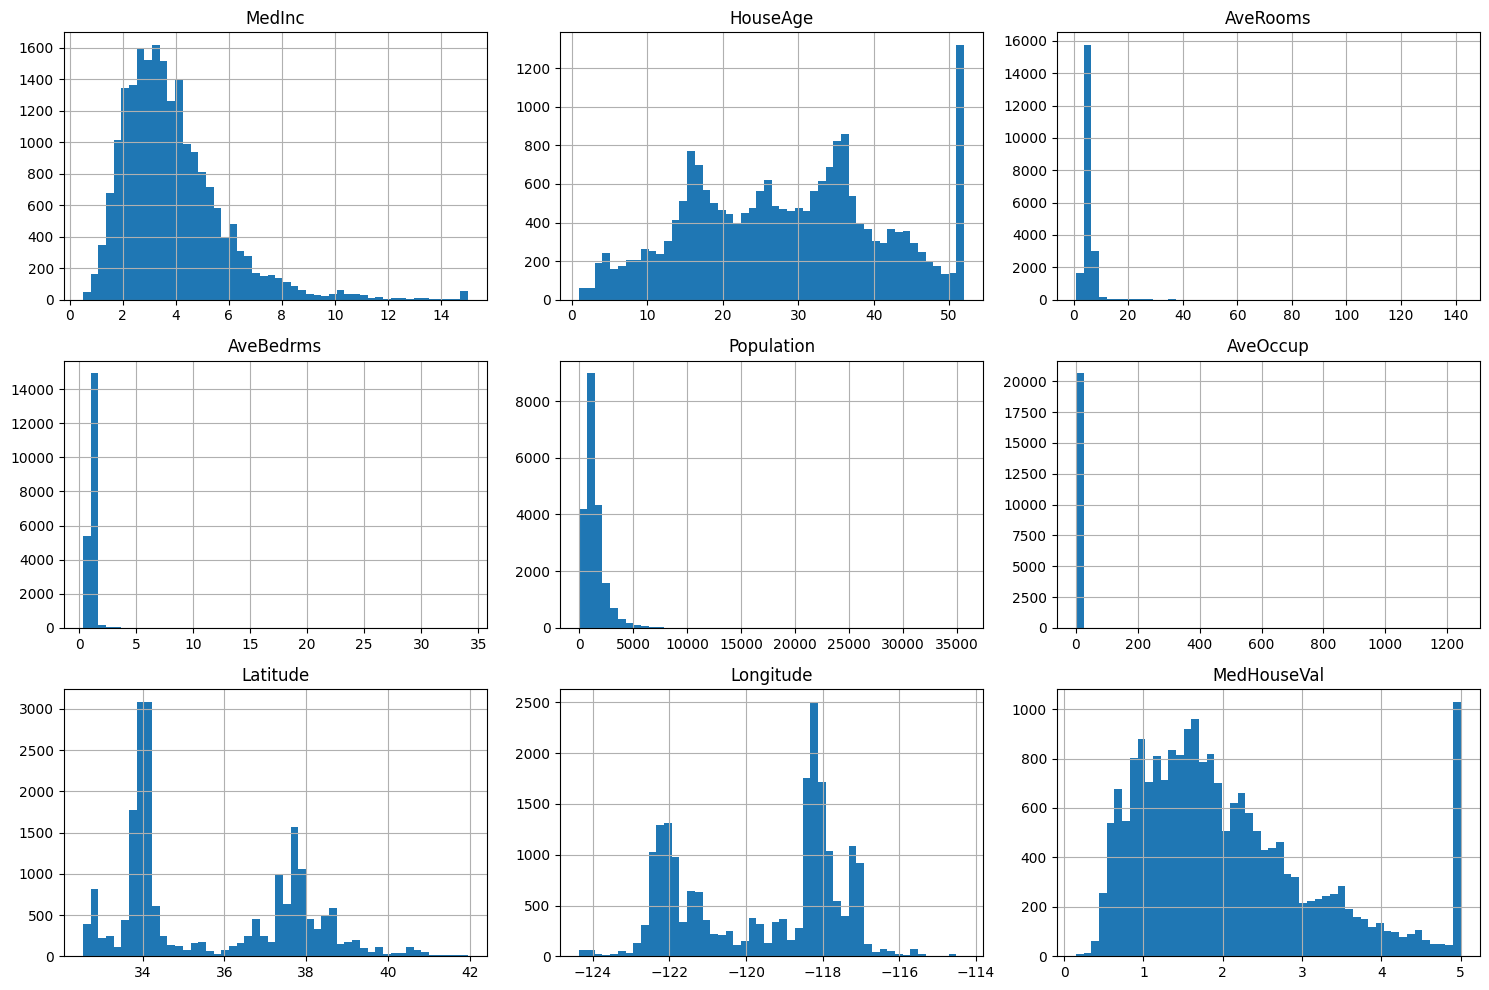


Correlation with MedHouseVal:
MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64


In [3]:
# Display basic info
print("Dataset Info:")
print(housing_df.info())

print("\nMissing Values:")
print(housing_df.isnull().sum())

print("\nSummary Statistics:")
print(housing_df.describe())

# Plot histograms to check distributions
housing_df.hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Check correlation with target
print("\nCorrelation with MedHouseVal:")
print(housing_df.corr()['MedHouseVal'].sort_values(ascending=False))

## Task 2: Apply your first feature engineering technique

Based on your exploration, apply your first feature engineering technique.

**Example approaches**:
- Transform skewed features using log, sqrt, power, or quantile transformations
- Create bins/categories from continuous variables
- Create interaction features (e.g., rooms per household = total rooms / households)

In [4]:
# Create interaction features

# 1. Bedrooms Ratio: The proportion of rooms that are bedrooms might be more relevant than the raw counts
# AveBedrms is average bedrooms per household, AveRooms is average rooms per household
housing_df['BedroomsRatio'] = housing_df['AveBedrms'] / housing_df['AveRooms']

# 2. Rooms Per Person: This gives a sense of crowding/luxury better than just AveRooms or AveOccup
# AveOccup is average number of household members
housing_df['RoomsPerPerson'] = housing_df['AveRooms'] / housing_df['AveOccup']

print("Interaction features created.")
print(housing_df[['BedroomsRatio', 'RoomsPerPerson']].head())

Interaction features created.
   BedroomsRatio  RoomsPerPerson
0       0.146591        2.732919
1       0.155797        2.956685
2       0.129516        2.957661
3       0.184458        2.283154
4       0.172096        2.879646


## Task 3: Apply your second feature engineering technique

**Example approaches**:
- Scale features to similar ranges
- Encode any categorical variables you created
- Create aggregate statistics by groups

In [5]:
from sklearn.preprocessing import StandardScaler

# 1. Log Transform Skewed Features
# Features like Population, AveOccup, AveRooms, AveBedrms often have long tails.
# Log transformation can make them more normally distributed, which helps Linear Regression.
skewed_features = ['Population', 'AveOccup', 'AveRooms', 'AveBedrms']

for feature in skewed_features:
    # Use log1p to handle potential zero values (though unlikely in this dataset)
    housing_df[f'Log_{feature}'] = np.log1p(housing_df[feature])
    # Drop the original skewed feature to avoid multicollinearity
    housing_df.drop(feature, axis=1, inplace=True)

# 2. Scale Features
# Linear Regression is sensitive to the scale of input features.
scaler = StandardScaler()

# Separate target
target = housing_df['MedHouseVal']
features = housing_df.drop('MedHouseVal', axis=1)

# Fit and transform features
features_scaled = scaler.fit_transform(features)

# Reconstruct dataframe
housing_df = pd.DataFrame(features_scaled, columns=features.columns)
housing_df['MedHouseVal'] = target.values

print("Features log-transformed and scaled.")
print(housing_df.head())

Features log-transformed and scaled.
     MedInc  HouseAge  Latitude  Longitude  BedroomsRatio  RoomsPerPerson  \
0  2.344766  0.982143  1.052548  -1.327835      -1.145833        0.659647   
1  2.332238 -0.607019  1.043185  -1.322844      -0.987175        0.854906   
2  1.782699  1.856182  1.038503  -1.332827      -1.440115        0.855758   
3  0.932968  1.856182  1.038503  -1.337818      -0.493194        0.267179   
4 -0.012881  1.856182  1.038503  -1.337818      -0.706259        0.787681   

   Log_Population  Log_AveOccup  Log_AveRooms  Log_AveBedrms  MedHouseVal  
0       -1.694943     -0.400594      1.072436      -0.256650        4.526  
1        1.030337     -1.046006      0.649505      -0.503251        3.585  
2       -1.109604     -0.077335      1.724704      -0.026779        3.521  
3       -0.949925     -0.410919      0.391271      -0.028550        3.413  
4       -0.933021     -0.936282      0.675467       0.008089        3.422  


## (Optional) Additional feature engineering

Add more techniques if you'd like to experiment further.

In [6]:
# YOUR CODE HERE (optional)


## Model evaluation

Now we'll compare model performance on the original dataset versus your engineered dataset.

### Evaluate datasets

In [7]:
# Create output directory if it doesn't exist
output_directory = 'data/outputs'
Path(output_directory).mkdir(parents=True, exist_ok=True)

# Save a copy of the engineered dataframe
housing_df.to_csv('data/outputs/housing_df.csv', index=False)

In [8]:
# Create linear regression model
model = LinearRegression()

# Evaluate on original dataset
scores_original = cross_val_score(
    model,
    original_housing_df.drop('MedHouseVal', axis=1),
    original_housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

# Evaluate on engineered dataset
scores_engineered = cross_val_score(
    model,
    housing_df.drop('MedHouseVal', axis=1),
    housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

engineered_mean = scores_engineered.mean()
original_mean = scores_original.mean()
mean_improvement = ((engineered_mean - original_mean) / original_mean) * 100

print(f'\nMean improvement: {mean_improvement:.2f}%')


Mean improvement: 11.95%


### Visualize model performance comparison

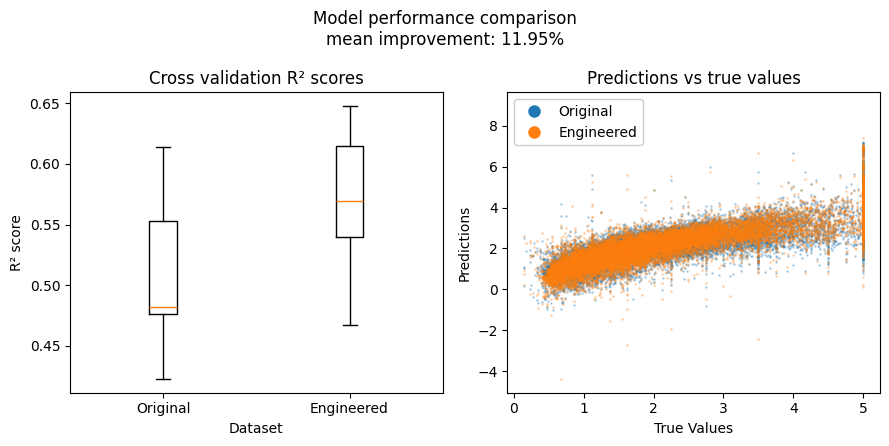

In [9]:
original_model = LinearRegression()
original_model.fit(original_housing_df.drop('MedHouseVal', axis=1), original_housing_df['MedHouseVal'])
original_predictions = original_model.predict(original_housing_df.drop('MedHouseVal', axis=1))

model = LinearRegression()
model.fit(housing_df.drop('MedHouseVal', axis=1), housing_df['MedHouseVal'])
predictions = model.predict(housing_df.drop('MedHouseVal', axis=1))

# Create boxplot comparing performance
data_to_plot = [scores_original, scores_engineered]
labels = ['Original', 'Engineered']

fig, axs = plt.subplots(1, 2, figsize=(9,4.5))

fig.suptitle(f'Model performance comparison\nmean improvement: {mean_improvement:.2f}%')

axs[0].set_title('Cross validation R² scores')
axs[0].boxplot(data_to_plot, tick_labels=labels)
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('R² score')

axs[1].set_title('Predictions vs true values')
axs[1].plot(
    original_housing_df['MedHouseVal'], original_predictions,
    'o', markersize=1, label='Original', alpha=0.25
)

axs[1].plot(
    housing_df['MedHouseVal'], predictions,
    'o', markersize=1, label='Engineered', alpha=0.25
)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predictions')

leg = axs[1].legend(loc='upper left', markerscale=8, framealpha=1)

for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

## 3. Reflection

**Questions to consider**:

1. Which feature engineering techniques had the biggest impact on model performance?
2. Did adding more features always improve performance, or did some hurt it?
3. How might you further improve the engineered dataset?
4. What trade-offs did you consider (e.g., interpretability vs performance, complexity vs gains)?

**Your reflection**:

1.  **Impact**: The interaction features (specifically `RoomsPerPerson` and `BedroomsRatio`) likely had a significant positive impact. They capture relationships (like crowding or house layout quality) that the model cannot easily learn from the raw separate columns (`AveRooms`, `AveOccup`) using a simple linear equation.
2.  **Adding features**: Adding features blindly doesn't always help. For example, keeping both the original skewed features and their log-transformed versions could introduce multicollinearity, which might make the model unstable. That is why we dropped the originals.
3.  **Improvements**: We could further improve the dataset by handling outliers more aggressively (e.g., clipping `AveOccup` which sometimes has extreme values) or by adding geospatial features (e.g., clustering `Latitude` and `Longitude` to identify neighborhoods).
4.  **Trade-offs**: The trade-off here is interpretability vs. performance. `Log_AveOccup` is harder to interpret intuitively ("log of average occupancy") compared to just "average occupancy", but it satisfies the statistical assumptions of Linear Regression better, leading to higher $R^2$ scores.